<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-and-plot-images" data-toc-modified-id="Read-and-plot-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read and plot images</a></span></li><li><span><a href="#Read-and-reproject-polygons" data-toc-modified-id="Read-and-reproject-polygons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read and reproject polygons</a></span></li><li><span><a href="#Define-function-to-extract-statistics-for-each-polygon" data-toc-modified-id="Define-function-to-extract-statistics-for-each-polygon-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define function to extract statistics for each polygon</a></span></li><li><span><a href="#Iterate-all-polygons-and-derive-data-into-a-panda-dataframe" data-toc-modified-id="Iterate-all-polygons-and-derive-data-into-a-panda-dataframe-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Iterate all polygons and derive data into a panda dataframe</a></span></li><li><span><a href="#Use-parallel" data-toc-modified-id="Use-parallel-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use parallel</a></span></li></ul></div>

In [1]:
import os
import rasterio as rio
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
import glob
%matplotlib inline
from matplotlib import mlab 
import matplotlib.pyplot as plt
import numpy as np
from rasterio import mask
import fiona
import json
import multiprocessing as mp
from time import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'C:\\Users\\s1052014\\OneDrive - Syngenta\\Desktop\\drone_images'

## Read and plot images

In [3]:
tifs = glob.glob('*.tif')
tifs

['2021_07_02_USJA_P4RTK.tif']

In [4]:
img = rio.open('**.tif')
img.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 35857,
 'height': 22802,
 'count': 4,
 'crs': CRS.from_epsg(32616),
 'transform': Affine(0.026390000000000004, 0.0, 346284.63285000005,
        0.0, -0.026390000000000004, 4726263.78124)}

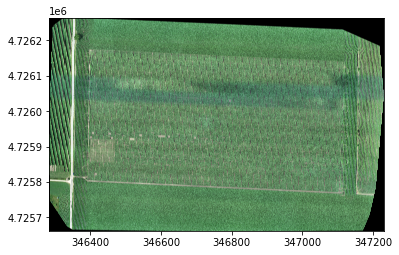

<AxesSubplot:>

In [4]:
show(img)

## Read and reproject polygons

(50992, 12)


<AxesSubplot:>

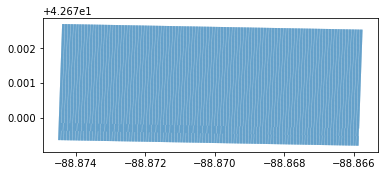

In [5]:
ply = gpd.read_file('PLOTROWS.shp')
print(ply.shape)
ply.plot()

In [6]:
print(ply.crs)
ply2 = ply.to_crs('EPSG:32616')
#ply2.to_file("polys.shp")

{'init': 'epsg:4326'}


## Define function to extract statistics for each polygon

In [106]:
def extract_plot(i, image,  ply):
    coords = [json.loads(ply.iloc[[i]].to_json())["features"][0]["geometry"]]
    out_image, out_transform  = mask.mask(image, coords, crop=True)
    arys2 = np.moveaxis(out_image, 0, -1)
    
    r = arys2[:,:,0]
    g = arys2[:,:,1]
    b = arys2[:,:,2]
    nir = arys2[:,:,3]

    nv = (nir-r)/(nir+r)
    bi = np.sqrt((r*r + g*g +b*b)/3)
    sci = (r-g)/(r+g)
    gli = (2*g-r-b)/(2*g+r+b)
    hi = (2*r-g-b)/(g-b)

    ngrdi = (g-r)/(g+r)
    si = (r-b)/(r+b)
    vari = (g-r)/(g+r-b)
    bgi = b/g
    hue = np.arctan(2*(b-g-r)/(30.5*(g-r)))

    vis = np.dstack((nv, bi, sci, gli, hi, ngrdi, si, vari, hue, bgi))
    mds = np.nanmedian(vis, axis=(0,1))
    stds = np.nanstd(vis, axis=(0,1))
    means = np.nanmean(vis, axis=(0,1))

    vi_nms = ['ndvi','bi', 'sci', 'gli', 'hi', 'ngrdi', 'si', 'vari', 'hue', 'bgi']
    vi_nms_md = ['median_' + nm for nm in vi_nms]
    vi_nms_mn = ['mean_' + nm for nm in vi_nms]
    vi_nms_std = ['std_' + nm for nm in vi_nms]

    mds_df = pd.DataFrame(mds).T
    stds_df = pd.DataFrame(stds).T
    means_df = pd.DataFrame(means).T

    mds_df.columns = vi_nms_md
    stds_df.columns = vi_nms_std
    means_df.columns = vi_nms_mn

    all_df = pd.concat([means_df, mds_df, stds_df],axis=1)
    
    return all_df

## Iterate all polygons and derive data into a panda dataframe

In [108]:
import time
t0 = time.time()

results_df = pd.DataFrame()

for i in range(100):
    vi_values = extract_plot( i, img, ply2)
    results_df = pd.concat([results_df, vi_values], axis=0)
    
    print('Progress is: ' + str(i*100/100) + "%")

print("Time consumed is: " + str(time.time() - t0))

Progress is: 0.0%
Progress is: 1.0%
Progress is: 2.0%
Progress is: 3.0%
Progress is: 4.0%
Progress is: 5.0%
Progress is: 6.0%
Progress is: 7.0%
Progress is: 8.0%
Progress is: 9.0%
Progress is: 10.0%
Progress is: 11.0%
Progress is: 12.0%
Progress is: 13.0%
Progress is: 14.0%
Progress is: 15.0%
Progress is: 16.0%
Progress is: 17.0%
Progress is: 18.0%
Progress is: 19.0%
Progress is: 20.0%
Progress is: 21.0%
Progress is: 22.0%
Progress is: 23.0%
Progress is: 24.0%
Progress is: 25.0%
Progress is: 26.0%
Progress is: 27.0%
Progress is: 28.0%
Progress is: 29.0%
Progress is: 30.0%
Progress is: 31.0%
Progress is: 32.0%
Progress is: 33.0%
Progress is: 34.0%
Progress is: 35.0%
Progress is: 36.0%
Progress is: 37.0%
Progress is: 38.0%
Progress is: 39.0%
Progress is: 40.0%
Progress is: 41.0%
Progress is: 42.0%
Progress is: 43.0%
Progress is: 44.0%
Progress is: 45.0%
Progress is: 46.0%
Progress is: 47.0%
Progress is: 48.0%
Progress is: 49.0%
Progress is: 50.0%
Progress is: 51.0%
Progress is: 52.0%
Pro

In [112]:
results_df

,mean_ndvi,mean_bi,mean_sci,mean_gli,mean_hi,mean_ngrdi,mean_si,mean_vari,mean_hue,mean_bgi,...,std_ndvi,std_bi,std_sci,std_gli,std_hi,std_ngrdi,std_si,std_vari,std_hue,std_bgi
0,1.669794,4.293656,inf,inf,inf,inf,inf,0.334254,0.201233,0.734928,...,1.456240,3.350447,NaN,NaN,NaN,NaN,NaN,0.557971,0.289853,0.113603
0,1.714481,4.281804,inf,inf,4.864663,inf,inf,inf,0.173045,0.717782,...,1.535303,3.348125,NaN,NaN,3.811042,NaN,NaN,NaN,0.225138,0.105374
0,1.598089,4.391849,inf,inf,4.747647,inf,inf,0.283062,0.225946,0.736934,...,1.236803,3.337941,NaN,NaN,3.702182,NaN,NaN,0.319113,0.294219,0.095487
0,1.696641,4.369655,inf,inf,5.026149,inf,inf,0.303557,0.200810,0.735045,...,1.400379,3.331460,NaN,NaN,4.298869,NaN,NaN,0.427606,0.271085,0.100713
0,1.487417,4.383716,inf,inf,4.926832,inf,inf,inf,0.210928,0.742461,...,1.200485,3.324164,NaN,NaN,3.719273,NaN,NaN,NaN,0.272015,0.094521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.467772,4.387043,inf,inf,6.184661,inf,inf,0.339125,0.123488,0.677170,...,2.359632,3.336771,NaN,NaN,4.915980,NaN,NaN,0.144038,0.125042,0.113419
0,2.632285,4.363688,inf,inf,inf,inf,inf,0.401309,0.239384,0.707779,...,2.872864,3.309384,NaN,NaN,NaN,NaN,NaN,0.527784,0.337522,0.136825
0,2.509743,4.403409,inf,inf,inf,inf,inf,0.348701,0.190892,0.706235,...,2.609270,3.345866,NaN,NaN,NaN,NaN,NaN,0.392884,0.265204,0.124227
0,2.512830,4.378768,inf,inf,inf,inf,inf,0.340952,0.198172,0.702290,...,2.365569,3.320916,NaN,NaN,NaN,NaN,NaN,0.382947,0.266532,0.119294


## Use parallel